In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Parameters
tickers = ['AMZN', 'AAPL', 'MSFT', 'META', 'GOOGL']
start_date, end_date = '2010-01-01', '2020-01-01'
num_simulation = int(10e4) # plot feasible portfolios and efficient frontier
risk_free_rate = 0.02

In [2]:
# Get price data from API
df_price = yf.download(tickers, start_date, end_date)['Adj Close']

# Transform the price data into return data
df_ret = df_price.pct_change().dropna()

df_ret

[*********************100%***********************]  5 of 5 completed


,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2012-05-21,0.058260,0.019921,0.022835,-0.109861,0.016399
2012-05-22,-0.007679,-0.012746,-0.021674,-0.089039,0.000336
2012-05-23,0.024400,0.009056,0.014414,0.032258,-0.021841
2012-05-24,-0.009184,-0.009389,-0.009517,0.032187,-0.001374
2012-05-25,-0.005360,-0.010918,-0.020094,-0.033909,-0.000344
...,...,...,...,...,...
2019-12-24,0.000951,-0.002114,-0.004591,-0.005141,-0.000191
2019-12-26,0.019840,0.044467,0.013418,0.013017,0.008197
2019-12-27,-0.000379,0.000551,-0.005747,0.001492,0.001828


In [3]:
# Define helper varibles for later use
N = len(tickers)
arr_ones = np.array([[1]*N]).T
arr_weights = np.array([[1/N]*N]).T
arr_expected_rets = (df_ret.mean().values*252)[np.newaxis,:].T # per annum
arr_cov_matrix = df_ret.cov().values*252 # per annum
arr_cov_matrix_inv = np.linalg.inv(arr_cov_matrix)

A = arr_ones.T @ arr_cov_matrix_inv @ arr_ones
B = arr_ones.T @ arr_cov_matrix_inv @ arr_expected_rets
C = arr_expected_rets.T @ arr_cov_matrix_inv @ arr_expected_rets
D = A*C - B**2

## Feasible portfolios and efficient frontier

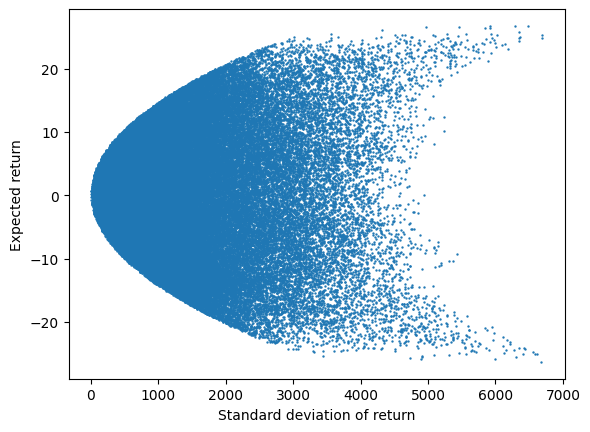

In [4]:
# Sample weights
arr_sims = np.random.uniform(-100, 100, (num_simulation,N-1)) # support can be any interval in reals
arr_sims = np.diff(arr_sims, prepend=0, append=1) # sum of the weights will be 1

# Compute return and standard deviation for the sample weights
arr_rets = arr_sims @ arr_expected_rets
# stds = np.diag( arr_sims @ arr_cov_matrix @ arr_sims.T ) # large matrix multimplication
arr_stds = []
for arr_sim in arr_sims:
  arr_stds.append(arr_sim @ arr_cov_matrix @ arr_sim.T)

plt.scatter(arr_stds, arr_rets, s=0.5)
plt.gca().update(dict(xlabel='Standard deviation of return', ylabel='Expected return'))
plt.show()

## Optimized portfolio
If the risk-free asset exists, the optimized portfolio is the tangent portfolio whose weight, expected return, and standard deviation of return are:

$ w_T = \frac{\Sigma^{-1} (E[r]-r_f)}{B-Ar_f} $

$ E[r_T] = \frac{C-Br_f}{B-Ar_f} $

$ \sigma(r_T) = \frac{AE[r_T]^2-2BE[r_T]+C}{D} $

In [5]:
# Optimized portfolio is the tangent portfolio
arr_optimized_weights = arr_cov_matrix_inv @ (arr_expected_rets - risk_free_rate*arr_ones) / (B - A*risk_free_rate)
print(f'The optimized weight is: {arr_optimized_weights.flatten()}')

The optimized weight is: [ 1.71290765e-01  2.83599826e-01 -2.63021255e-04  1.06766904e-01
  4.38605525e-01]


In [6]:
# The corresponding expected return and the standard deviation of return
opt_expected_ret = (arr_optimized_weights.T @ arr_expected_rets)[0,0]
opt_std = (arr_optimized_weights.T @ arr_cov_matrix @ arr_optimized_weights)[0,0]
print(f'The expected return is: {opt_expected_ret:.4f}')
print(f'The standard deviation of return is: {opt_std:.4f}')

The expected return is: 0.2810
The standard deviation of return is: 0.0410


In [7]:
# Using formula to find the expected return and the standard deviation of return
opt_expected_ret_1 = ((C - B*risk_free_rate)/(B - A*risk_free_rate))[0,0]
opt_std_1 = ((A*opt_expected_ret**2 - 2*B*opt_expected_ret + C)/D)[0,0]
print(f'The expected return is: {opt_expected_ret_1:.4f}')
print(f'The standard deviation of return is: {opt_std_1:.4f}')

The expected return is: 0.2810
The standard deviation of return is: 0.0410


## Wrap up the code into a class

In [8]:
class MPT:

  def __init__(self, tickers = ['AMZN', 'AAPL', 'MSFT', 'META', 'GOOGL'],
               start_date = '2010-01-01', end_date = '2020-01-01', risk_free_rate = 0.02):
    self.tickers = tickers
    self.start_date = start_date
    self.end_date = end_date
    self.risk_free_rate = risk_free_rate

  def get_ret_data(self):
    self.df_ret = yf.download(self.tickers, self.start_date, self.end_date)['Adj Close'].pct_change().dropna()

  def optimized_portfolio(self):
    N = len(self.tickers)
    arr_ones = np.array([[1]*N]).T
    arr_weights = np.array([[1/N]*N]).T
    arr_expected_rets = (self.df_ret.mean().values*252)[np.newaxis,:].T # per annum
    arr_cov_matrix = self.df_ret.cov().values*252 # per annum
    arr_cov_matrix_inv = np.linalg.inv(arr_cov_matrix)

    A = arr_ones.T @ arr_cov_matrix_inv @ arr_ones
    B = arr_ones.T @ arr_cov_matrix_inv @ arr_expected_rets
    C = arr_expected_rets.T @ arr_cov_matrix_inv @ arr_expected_rets
    D = A*C - B**2

    arr_optimized_weights = arr_cov_matrix_inv @ (arr_expected_rets - risk_free_rate*arr_ones) / (B - A*self.risk_free_rate)
    opt_expected_ret = ((C - B*risk_free_rate)/(B - A*risk_free_rate))[0,0]
    opt_std = ((A*opt_expected_ret**2 - 2*B*opt_expected_ret + C)/D)[0,0]

    print(f'The optimized weight is: {arr_optimized_weights.flatten()}')
    print(f'The expected return is: {opt_expected_ret:.4f}')
    print(f'The standard deviation of return is: {opt_std:.4f}')


In [9]:
mpt0 = MPT()
mpt0.get_ret_data()
mpt0.optimized_portfolio()

[*********************100%***********************]  5 of 5 completed
The optimized weight is: [ 1.71290527e-01  2.83599578e-01 -2.62701215e-04  1.06766824e-01
  4.38605772e-01]
The expected return is: 0.2810
The standard deviation of return is: 0.0410
